In [18]:
import os
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch import optim
import numpy as np
from collections import OrderedDict
import time
import random
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [27]:
synth_data = open("rating_10k_synths.csv", "r").readlines()

train_test_percentage = 0.90
cutoff = int(train_test_percentage * len(synth_data))

# stupid extract data from csv
# organized by:
#  song_name | num of plays | [values...]
lines = [l.replace('\n', '').split('\t') for l in synth_data]

random.shuffle(lines)

my_x = [[float(i) for i in l[2:]] for l in lines]
my_y = [float(l[1]) for l in lines]
my_y_max = np.amax(my_y)

my_y = [(y/my_y_max)**(0.4) for y in my_y]

# splice dataset
train_x = my_x[:cutoff]
train_y = my_y[:cutoff]
test_x = my_x[cutoff:]
test_y = my_y[cutoff:]

# prepare tensors
tensor_train_x = torch.Tensor(train_x) # transform to torch tensor
tensor_train_y = torch.Tensor(train_y)
tensor_test_x = torch.Tensor(test_x) # transform to torch tensor
tensor_test_y = torch.Tensor(test_y)

train_dataset = TensorDataset(tensor_train_x,tensor_train_y) # create your datset
train_dataloader = DataLoader(train_dataset) # create your dataloader
test_dataset = TensorDataset(tensor_test_x,tensor_test_y) # create your datset
test_dataloader = DataLoader(test_dataset) # create your dataloader


(array([4.210e+02, 5.110e+02, 7.260e+02, 1.271e+03, 7.020e+02, 4.410e+02,
        3.470e+02, 2.720e+02, 1.940e+02, 1.540e+02, 1.390e+02, 6.800e+01,
        5.900e+01, 4.800e+01, 3.100e+01, 9.000e+00, 7.000e+00, 6.000e+00,
        3.000e+00, 1.000e+00]),
 array([0.00190523, 0.04883092, 0.09575661, 0.14268231, 0.189608  ,
        0.23653369, 0.28345939, 0.33038508, 0.37731077, 0.42423647,
        0.47116216, 0.51808785, 0.56501355, 0.61193924, 0.65886494,
        0.70579063, 0.75271632, 0.79964202, 0.84656771, 0.8934934 ,
        0.9404191 ]),
 <BarContainer object of 20 artists>)

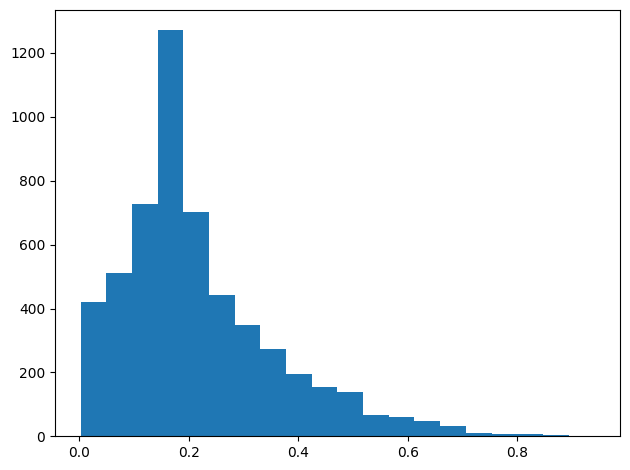

In [28]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs.hist(train_y, bins=20)

In [29]:
# evaluate a single tensor
def test_model(target):
    #X = torch.rand(1, 527, 1, device=device)
    #target = cutoff + 1
    X = torch.tensor(my_x[target])
    start = time.perf_counter_ns()
    #print(X.shape)
    logits = model(X)
    end = time.perf_counter_ns()
    print(f"Testing took: {(end - start)/1000000}ms")
    print(f"index[{target}] : {logits[0]:>0.4f} vs {my_y[target]:>0.4f}")
    #print(f"Predicted class: {y_pred}")

In [30]:
def describe_model(model):
    print(f"Model structure: {model}\n\n")

    for name, param in model.named_parameters():
        print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

In [31]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 500:
            loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

#pdist = torch.nn.PairwiseDistance(p=2)
def validate_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset) // int(1)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, errors = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            #print(f"Got pred: {pred.sum().item()}\tfor y: {y[0]}")
            test_loss += loss_fn(pred, y).item()
            errors += (abs(pred.sum().item() - y[0]))
    test_loss /= num_batches
    errors /= size
    correct = 1 - errors
    if progress % 1 == 0 or progress == 0:
        print(
            f"Epoch {str(progress).zfill(2)}  "
            f"Accuracy: {(100 * correct):>0.1f}%  "
            f"Avg loss: {test_loss:>8f}  [{'X'*int(50*correct)}{'-'*int(50*(1-correct))}]"
        )
    return test_loss

In [32]:
def export_model(expmodel):
    dummy_input = torch.randn(1, 1, 527)
    torch.onnx.export(expmodel,
                 dummy_input,
                 "tridonn.onnx",
                 verbose=True,
                 input_names=["dense1"],
                 output_names=["outact"],
                 export_params=True,
                 )

In [33]:
def rate_file(filename):
    rate_file = open(filename, "r").readlines()
    rate_lines = [l.replace('\n', '').split('\t') for l in rate_file]

    my_test_x = [[float(i) for i in l[1:]] for l in rate_lines[1:]]
    song_names = [l[0] for l in rate_lines[1:]]
    
    print("Song ratings: [0-1]")
    
    results = {}
    
    for i in range(len(my_test_x)):
        X = torch.tensor(my_test_x[i])
        song_name = song_names[i].split('/')[-1]
        logits = model(X)
        #end = time.perf_counter_ns()
        #print(f"Testing took: {(end - start)/1000000}ms")
        #print(f"index[{target}] : {logits[0]:>0.4f} vs {my_y[target]:>0.4f}")
        results[song_name] = float(logits[0])

        #print(f"{song_name} = {logits[0]:>0.4f}")
    return results
    

In [34]:
#model = NeuralNetwork().to(device)

N0 = 527
N1 = 10
N2 = 1
NX = 1

model = nn.Sequential(OrderedDict([
    ('dense1', nn.Linear(N0, N1)),
    ('act1', nn.ReLU()),
    ('dense2', nn.Linear(N1, N2)),
    #('act2', nn.ReLU()),
    #('output', nn.Linear(N2, NX)),
    ('outact', nn.Sigmoid()),
]))

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
epochs = 3
progress = 0

target = 201

# before training (sanity check)
print("Before:")
test_model(target)

loss = validate_epoch(test_dataloader, model, loss_fn)

train_time = 0
print("\nTraining:")

for i in range(epochs):
    progress += 1
    start = time.perf_counter_ns()
    train_epoch(train_dataloader, model, loss_fn, optimizer)
    train_time += time.perf_counter_ns() - start
    loss = validate_epoch(test_dataloader, model, loss_fn)
    
    # eval
    #values = rate_file("my_fun_playlist.csv")
    #print('\n'.join([f"{f[0]}: {f[1]}" for f in sorted(values.items(), key=lambda x: -x[1])[:5]]))
    #print('\n'.join([f"{f[0]}: {f[1]}" for f in sorted(values.items(), key=lambda x: -x[1])[-5:]]))
    #session.report(dict(loss=loss))

print(f"Training took: {(train_time)/1000000}ms")

print("\nTesting:")
start = time.perf_counter_ns()
test_model(target)
end = time.perf_counter_ns()
print(f"Testing took: {(end - start)/1000000}ms")
    
torch.save(model.state_dict(), 'tridonn')
print(os.path.getsize('tridonn'))

Before:
Testing took: 0.254513ms
index[201] : 0.4922 vs 0.6294
Epoch 00  Accuracy: 70.8%  Avg loss: 0.098720  [XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--------------]

Training:
Epoch 01  Accuracy: 89.3%  Avg loss: 0.019760  [XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX-----]
Epoch 02  Accuracy: 89.4%  Avg loss: 0.019617  [XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX-----]
Epoch 03  Accuracy: 89.4%  Avg loss: 0.019550  [XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX-----]
Training took: 10648.497242ms

Testing:
Testing took: 0.311548ms
index[201] : 0.1999 vs 0.6294
Testing took: 0.49145ms
22751


In [35]:
# export for onnx
export_model(model)

Exported graph: graph(%dense1 : Float(1, 1, 527, strides=[527, 527, 1], requires_grad=0, device=cpu),
      %dense1.bias : Float(10, strides=[1], requires_grad=1, device=cpu),
      %dense2.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %onnx::MatMul_13 : Float(527, 10, strides=[1, 527], requires_grad=0, device=cpu),
      %onnx::MatMul_14 : Float(10, 1, strides=[1, 10], requires_grad=0, device=cpu)):
  %/dense1/MatMul_output_0 : Float(1, 1, 10, strides=[10, 10, 1], device=cpu) = onnx::MatMul[onnx_name="/dense1/MatMul"](%dense1, %onnx::MatMul_13), scope: torch.nn.modules.container.Sequential::/torch.nn.modules.linear.Linear::dense1 # /home/tristan/.local/lib/python3.10/site-packages/torch/nn/modules/linear.py:114:0
  %/dense1/Add_output_0 : Float(1, 1, 10, strides=[10, 10, 1], requires_grad=1, device=cpu) = onnx::Add[onnx_name="/dense1/Add"](%dense1.bias, %/dense1/MatMul_output_0), scope: torch.nn.modules.container.Sequential::/torch.nn.modules.linear.Linear::dense1 #

### Inference

In [37]:
start = time.perf_counter_ns()

#values = rate_file("addict11-loved-tracks_ana_results.csv")
values = rate_file("my_fun_playlist.csv")

end = time.perf_counter_ns()
print(f"Testing took: {(end - start)/1000000}ms")
dict(sorted(values.items(), key=lambda x: -x[1]))

Song ratings: [0-1]
Testing took: 26.420665ms


{'3670232 - Passion Pit - Manners - Sleepyhead.m4a.wav': 0.24408693611621857,
 '35410166 - Galantis - Runaway (U & I) - Runaway (U & I).m4a.wav': 0.24288801848888397,
 '74886176 - Portugal. The Man - Woodstock - Tidal Wave.m4a.wav': 0.23303045332431793,
 '85108589 - Digitalism - Zdar C1u6 - Holograms.m4a.wav': 0.2330245077610016,
 '198746918 - Die Antwoord - Donker Mag - Strunk.m4a.wav': 0.2321891039609909,
 '226480299 - Flume - TheSoundYouNeed, Vol. 1 - Drop The Game.m4a.wav': 0.2302871197462082,
 '49990992 - Glass Animals - ZABA (Deluxe) - Gooey.m4a.wav': 0.22990146279335022,
 '59881210 - KAYTRANADA - 99.9% - GOT IT GOOD.m4a.wav': 0.22944870591163635,
 '82440278 - Flume - Flume- Deluxe Edition - Insane (L D R U Remix).m4a.wav': 0.22871091961860657,
 '64145296 - Glass Animals - How To Be A Human Being - The Other Side Of Paradise.m4a.wav': 0.22756868600845337,
 '54329308 - Miike Snow - Genghis Khan - Genghis Khan.m4a.wav': 0.2275334894657135,
 '74447704 - alt-J - RELAXER - Deadcrush.m

In [ ]:
#test_model(2237)

index[2237] : 0.0323 vs 0.0247


# Useless stuff

In [89]:
"*"*8

'********'

In [12]:

def train_func(config):
    batch_size = config["batch_size"]
    lr = config["lr"]
    epochs = config["epochs"]

    worker_batch_size = 2
    #worker_batch_size = batch_size // session.get_world_size()

    # Create data loaders.
    train_dataloader = DataLoader(training_data, batch_size=worker_batch_size)
    test_dataloader = DataLoader(test_data, batch_size=worker_batch_size)

    train_dataloader = train.torch.prepare_data_loader(train_dataloader)
    test_dataloader = train.torch.prepare_data_loader(test_dataloader)

    # Create model.
    model = NeuralNetwork()
    model = train.torch.prepare_model(model)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for _ in range(epochs):
        train_epoch(train_dataloader, model, loss_fn, optimizer)
        loss = validate_epoch(test_dataloader, model, loss_fn)
        session.report(dict(loss=loss))

#train_func({"lr": 1e-3, "batch_size": 64, "epochs": 4})
#print(f"Last result: {result.metrics}")

In [73]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(527, 1024),
            nn.ReLU(),
            nn.Linear(1024, 100),
            nn.ReLU(),
            #nn.Linear(527, 20),
            #nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        #x = F.relu(self.linear_relu_stack[0](x))
        #x = F.relu(self.linear_relu_stack[1](x))
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        #logits = nn.functional.softmax(logits, dim=1)
        return logits
        #return self.linear_relu_stack[2](x)

In [99]:
input_image = torch.rand(3,527,1)
print(input_image.size())
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 527, 1])
torch.Size([3, 527])


In [116]:
model = NeuralNetwork().to(device)
print(model)
lr = 0.01

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=527, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
